In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

from keras.callbacks import ReduceLROnPlateau
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Conv2D, GlobalMaxPooling2D, MaxPooling2D, Flatten, Concatenate
from keras import layers as kl
# Conv2D, Input, Flatten, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization

from keras.applications.nasnet import NASNetLarge

%matplotlib inline

Using TensorFlow backend.


In [20]:
from utils.preprocess import DataGenerator
from utils.callbacks import PlotCurves
from utils.load_data import load_data
from utils.comparams import calculate_auc, auc
from utils.tester import run_test

### Data Generator

In [4]:
data_dir = './data/macenko/'

In [5]:
x_train, y_train, x_valid, y_valid = load_data(data_dir, purpose='train', 
                                               limit=None, val_limit=None, norm='macenko')
len(x_train), len(x_valid)

(261756, 32728)

In [6]:
# indexes
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_valid))

# create a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id
    
train_labels = {str(i) : y_train[i].flatten()[0] for i in train_id}
val_labels = {str(i) : y_valid[i].flatten()[0] for i in val_id}

In [7]:
del train_id
del val_id
del data_dir

## MODEL

In [8]:
def build_arch_8_net():
    
    inputs = Input((96, 96, 3))
    nasnet = NASNetLarge(input_tensor=inputs, weights='imagenet', include_top=False)
    x = nasnet.output
#     x = Conv2D(32, (1,1), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    y = Dense(2, activation='softmax')(x)
    
    # Train only the top layer
    for layer in nasnet.layers:
        layer.trainable = False

    model = Model(inputs=inputs, outputs=y)

    return model

In [9]:
def build_arch_10_net():
    
    inputs = Input((96, 96, 3))
    nasnet = NASNetLarge(input_tensor=inputs, weights='imagenet', include_top=False)
    x = nasnet.output
    x = Conv2D(32, (1,1), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    y = Dense(2, activation='softmax')(x)
    
    # Train only the top layer
    for layer in nasnet.layers:
        layer.trainable = False

    model = Model(inputs=inputs, outputs=y)

    return model

In [10]:
model = build_arch_8_net()

W0616 23:44:26.491729 140335792910464 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0616 23:44:26.504105 140335792910464 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0616 23:44:26.506195 140335792910464 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0616 23:44:26.519470 140335792910464 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/t

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 47, 47, 96)   2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 47, 47, 96)   384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 47, 47, 96)   0           stem_bn1[0][0]                   
__________________________________________________________________________________________________
reduction_

### Compile

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_auc', 
                                            patience=2,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000005)

In [13]:
optimizer = Adam(lr=0.001)
loss = 'binary_crossentropy'
metrics = ['acc', auc]

In [14]:
model.compile(optimizer, loss, metrics)

W0616 23:44:55.191102 140335792910464 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0616 23:44:55.196062 140335792910464 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3378: The name tf.nn.sigmoid_cross_entropy_with_logits is deprecated. Please use tf.nn.sigmoid_cross_entropy_with_logits instead.

W0616 23:44:55.197545 140335792910464 deprecation.py:323] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:179: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0616 23:44:55.211

## Train the model

In [15]:
model_name = 'nasnet_model_bin_cross_arch_8_lr_0_001_inp96'

In [16]:
batch_size = 128
n_epoch = 15

# Parameters for generators
train_params = {
    'dim': (96, 96),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': True,
    'shuffle': True
}

val_params = {
    'dim': (96, 96),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': False,
    'shuffle': True
}

# Generators
training_generator = DataGenerator(partition['train'], x_train, train_labels, **train_params)
validation_generator = DataGenerator(partition['validation'], x_valid, val_labels, **val_params)

In [17]:
# Callbacks
callbacks = [PlotCurves(model_name=model_name, weights2pickle=True), learning_rate_reduction]

In [18]:
del x_train
del x_valid
del y_train
del y_valid
del train_labels
del val_labels

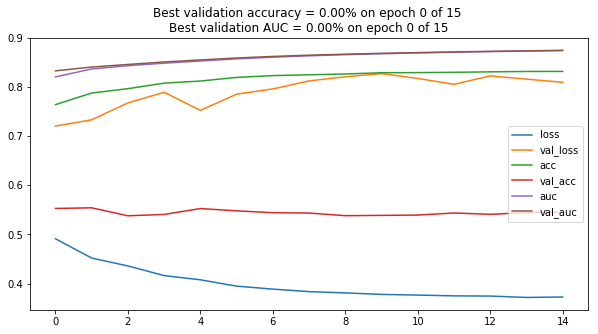


Epoch 00015: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.


In [19]:
# Training with learning 
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks)

In [21]:
run_test('./Model/nasnet_model_bin_cross_arch_8_lr_0_001_inp96/nasnet_model_bin_cross_arch_8_lr_0_001_inp96_epoch_15.h5')

OSError: Unable to open file (unable to open file: name = './Model/nasnet_model_bin_cross_arch_8_lr_0_001_inp96/nasnet_model_bin_cross_arch_8_lr_0_001_inp96_epoch_15.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [23]:
x_test, y_test_true = load_data('data/macenko/', purpose='test', norm='macenko')

In [24]:
# indexes
test_id = np.arange(len(x_test))

partition = {}
partition['test'] = test_id

test_labels = {str(i) : y_test_true[i].flatten()[0] for i in test_id}

# Parameters for generators
params = {
    'dim': (96, 96),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': False,
    'shuffle': False
}

# Generators
test_generator = DataGenerator(partition['test'], x_test, test_labels, **params)

In [25]:
preds = model.predict_generator(test_generator)

In [26]:
true_labels = np.array(y_test_true).flatten()
pred_labels = np.array([p[1] for p in preds])
calculate_auc(true_labels, pred_labels)

sklearn auc: 0.6175513090938857
tf auc: [0.6175327, 0.6175327]
